<h3>Задачи</h3>
1. Рассчитать LTV, ROMI юзера, используя когортный анализ.<br>
2. Спрогнозировать LTV, ROMI, Retention на полгода.<br>
3. Построить график, отражающий кривую фактического LTV на фоне кривой прогнозируемого LTV.<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 150)
import warnings
warnings.filterwarnings("ignore")

In [2]:
patch = '/Users/olgapalchul/Downloads/' 
df = pd.read_excel(patch + 'test case data analyst.xlsx')

посмотрим содержание документа, удалим дубликаты и др

In [3]:
# df.head()
# df[df.duplicated()]

print(df.duplicated().sum())
df = df.drop_duplicates()

84


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114116 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114116 non-null  object        
 1   quantity         114116 non-null  int64         
 2   is_trial_period  114116 non-null  bool          
 3   purchase_date    114116 non-null  datetime64[ns]
 4   user_id          114116 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 4.5+ MB


In [5]:
print(df.purchase_date.max(), df.purchase_date.min())

2020-02-20 00:00:00 2020-01-01 00:00:00


Данные о новых пользователях за 7,5 недели 2020 года. Будем считать датой регистрации пользователя на сайте/приложении дату оформления 7-дневного триала (is_trial_period == True), конверсией в покупку - переход на is_trial_period == False. 

In [6]:
df.groupby('user_id', as_index=False)['product_id'].count().sort_values(by='product_id', ascending=False).head()
#максимум количества оформления подписок - 8 шт (1 trial и 7 платных подписок), минимум - 1 (trial)

,user_id,product_id
6299,8212763,8
5965,8205186,8
2132,5280028,8
5849,8201928,8
6566,8218787,8


In [7]:
#найдем пользователей, у которых два состояния is_trial_period, т.е. переходили из trial в платную подписку
conv = df.groupby('user_id', as_index=False)['is_trial_period'].nunique().sort_values(by='is_trial_period', ascending=False)
conv_users= conv[conv.is_trial_period > 1]
print('Пользователей всего:', df.user_id.nunique())
print('Пользователей купивших подписку:', conv_users.user_id.nunique()) # всего 19546 юзеров, у которых поменялся is_trial_period с True на  False


Пользователей всего: 62909
Пользователей купивших подписку: 19546


<h3>Расчет LTV,ROMI по имеющимся данным</h3>
Датой формирования когорты будем считать дату оформления бесплатной подписки. Поэтому в первую неделю сущестовования когорта не приносит прибыль. Основная сложность расчета когортного анализа с подпиской состоит в том, что невозможно выделить строго календарную неделю (пн-вс) для каждой новой когорты, кагорты формируется ежедневно и отсчет триала идет, например, вт-вт следующей недели или ср-ср недели. Вторая сложность - хвост оформления подписок после истечения недели. Большая часть оформления платной подписки происход с интервалом ровно 7 дней, но также будет часть пользователей, которая оформит подписку на 8,9 дней после оформления триала. В этом анализе для простоты мы проигнорируем единичные подписки, оформленые раньше окончания триала. Стоит отметить, что когортный анализ лучше проводить по каждому источнику привлечения отдельно. 
<h4>Расчет LTV</h4>

In [8]:
# выделяем дату оформления бесплатной подписки
df_first = df.groupby('user_id', as_index=False)['purchase_date'].min().sort_values(by='purchase_date').rename(columns={'purchase_date': 'first_date'})
df = df.merge(df_first, how='left', on='user_id')

df['first_week_date'] = df['first_date'].dt.isocalendar().week
df['week_purchase'] = df['purchase_date'].dt.isocalendar().week
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_date,first_week_date,week_purchase
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,7,8
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,7,8
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,7,8
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,7,8
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,3,7


In [9]:
size_cohorts = df.groupby('first_date', as_index=False)['user_id'].nunique().rename(columns={'user_id': 'size_cohorts'})
df = df.merge(size_cohorts, how='left', on='first_date')
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_date,first_week_date,week_purchase,size_cohorts
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,7,8,1539
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,7,8,1408
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,7,8,1390
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,7,8,1390
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,3,7,1127


In [10]:
# df.groupby('week_date', as_index=False)['user_id'].nunique()
df_pivot = df.pivot_table(
    index='first_date',
    columns='week_purchase',
    values='user_id',
    aggfunc='nunique',
)
df_pivot.head(10)

week_purchase,1,2,3,4,5,6,7,8
first_date,,,,,,,,
2020-01-01,906.0,338.0,279.0,253.0,236.0,211.0,193.0,156.0
2020-01-02,1300.0,486.0,412.0,348.0,316.0,281.0,260.0,86.0
2020-01-03,1439.0,520.0,422.0,372.0,341.0,302.0,268.0,21.0
2020-01-04,1459.0,552.0,441.0,388.0,357.0,332.0,299.0,30.0
2020-01-05,1525.0,572.0,473.0,427.0,385.0,363.0,323.0,33.0
2020-01-06,NaN,1359.0,490.0,389.0,346.0,299.0,271.0,212.0
2020-01-07,NaN,1190.0,424.0,346.0,301.0,267.0,230.0,181.0
2020-01-08,NaN,1126.0,393.0,320.0,276.0,256.0,244.0,182.0
2020-01-09,NaN,1204.0,372.0,314.0,271.0,239.0,225.0,68.0


если грубо округлить - на покупку платной подписки (2я неделя жизни для каждой когорты) соглашается чуть больше трети, взявших триал

In [11]:
df_pivot1 = df.pivot_table(
    index='first_date',
    columns='purchase_date',
    values='user_id',
    aggfunc='nunique',
)
df_pivot1.head()

purchase_date,2020-01-01,2020-01-02,2020-01-03,2020-01-04,2020-01-05,2020-01-06,2020-01-07,2020-01-08,2020-01-09,2020-01-10,2020-01-11,2020-01-12,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20
first_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,906.0,NaN,NaN,NaN,NaN,NaN,NaN,319.0,4.0,8.0,3.0,4.0,3.0,3.0,256.0,6.0,5.0,2.0,4.0,4.0,1.0,229.0,12.0,3.0,1.0,3.0,4.0,1.0,196.0,9.0,13.0,10.0,4.0,4.0,4.0,174.0,8.0,11.0,7.0,3.0,2.0,3.0,158.0,8.0,10.0,9.0,3.0,4.0,2.0,146.0,4.0
2020-01-02,NaN,1300.0,NaN,1.0,NaN,NaN,NaN,NaN,465.0,11.0,8.0,2.0,8.0,2.0,8.0,372.0,13.0,7.0,3.0,9.0,4.0,5.0,308.0,11.0,8.0,3.0,6.0,4.0,9.0,273.0,13.0,6.0,5.0,2.0,8.0,10.0,239.0,11.0,5.0,6.0,5.0,7.0,8.0,215.0,14.0,7.0,4.0,6.0,7.0,5.0,68.0
2020-01-03,NaN,NaN,1439.0,NaN,NaN,NaN,NaN,NaN,NaN,511.0,6.0,3.0,4.0,4.0,8.0,1.0,391.0,8.0,6.0,3.0,5.0,7.0,12.0,326.0,13.0,6.0,8.0,4.0,7.0,15.0,285.0,14.0,8.0,8.0,9.0,4.0,15.0,246.0,14.0,6.0,9.0,8.0,5.0,14.0,214.0,14.0,4.0,5.0,8.0,6.0,2.0
2020-01-04,NaN,NaN,NaN,1459.0,1.0,NaN,1.0,NaN,NaN,NaN,545.0,7.0,4.0,6.0,2.0,2.0,12.0,407.0,8.0,3.0,6.0,5.0,9.0,18.0,335.0,12.0,8.0,12.0,6.0,11.0,24.0,286.0,10.0,9.0,16.0,9.0,13.0,19.0,256.0,10.0,9.0,14.0,12.0,12.0,15.0,224.0,13.0,10.0,15.0,4.0,1.0
2020-01-05,NaN,NaN,NaN,NaN,1525.0,2.0,NaN,NaN,NaN,NaN,1.0,569.0,10.0,5.0,5.0,5.0,8.0,3.0,437.0,7.0,6.0,8.0,17.0,10.0,6.0,373.0,8.0,10.0,10.0,24.0,19.0,12.0,302.0,13.0,14.0,11.0,25.0,14.0,13.0,273.0,14.0,10.0,8.0,24.0,11.0,10.0,246.0,11.0,9.0,9.0,4.0


Единицы пользователей оформляют подписку до истечения триала.<br>
Продажи основного числа подписок цикличны – один раз в семь дней, с каждой неделей количество подписчиков уменьшается.<br>
Есть «хвост» в человек 30-35 между основными подписками.

In [12]:
df['week_after_trial'] = ((df['purchase_date'] - df['first_date']))
df['week_after_trial'] = np.floor(df['week_after_trial'] / np.timedelta64(1,'W'))
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_date,first_week_date,week_purchase,size_cohorts,week_after_trial
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,7,8,1539,1.0
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,7,8,1408,1.0
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,7,8,1390,1.0
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,7,8,1390,1.0
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,3,7,1127,4.0


In [13]:
df_pivot2 = df.pivot_table(
    index='first_date',
    columns='week_after_trial',
    values='user_id',
    aggfunc='nunique',
)
df_pivot2.head()

week_after_trial,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
first_date,,,,,,,,
2020-01-01,906.0,344.0,278.0,253.0,239.0,208.0,194.0,150.0
2020-01-02,1300.0,503.0,412.0,349.0,317.0,281.0,258.0,68.0
2020-01-03,1439.0,537.0,432.0,379.0,343.0,302.0,253.0,NaN
2020-01-04,1459.0,577.0,456.0,408.0,362.0,328.0,267.0,NaN
2020-01-05,1525.0,605.0,491.0,456.0,392.0,350.0,279.0,NaN


мы получили когорты по дням формирования. 0-я неделя - это триальная неделя, далее идут недели жизни для каждой кагорты. Например, для кагорты, сформированной 2020-01-01 триал оформило 906 человек, платную подписку после триала взяло 344 чел, вторую платную подписку через неделю взяло 278 чел и т.д. Добавим столбец с оплатой

In [14]:
def revenue_week(data):
    
    """ функция возвращает сумму, полученную с юзера после триала"""
    
    if data['week_after_trial'] == 0:
        return 0
    if data['week_after_trial'] != 0:
        return 4.99
        
df['revene_week'] = df.apply(revenue_week, axis=1)
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_date,first_week_date,week_purchase,size_cohorts,week_after_trial,revene_week
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,7,8,1539,1.0,4.99
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,7,8,1408,1.0,4.99
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,7,8,1390,1.0,4.99
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582,2020-02-11,7,8,1390,1.0,4.99
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,3,7,1127,4.0,4.99


In [15]:
df['revenue_per_user'] = df['revene_week'] / df['size_cohorts']

df_pivot_revenue = df.pivot_table(
    index='first_date',
    columns='week_after_trial',
    values='revenue_per_user',
    aggfunc='sum',
)
df_pivot_revenue = df_pivot_revenue.fillna('') 
df_pivot_revenue.head(10)

week_after_trial,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
first_date,,,,,,,,
2020-01-01,0.0,1.894658,1.531148,1.393455,1.321854,1.145607,1.068499,0.826159
2020-01-02,0.0,1.934585,1.585285,1.339623,1.216792,1.078608,0.990323,0.261015
2020-01-03,0.0,1.862147,1.49804,1.314253,1.189416,1.047241,0.877325,
2020-01-04,0.0,1.976847,1.559589,1.395422,1.238095,1.121809,0.91318,
2020-01-05,0.0,1.979639,1.606616,1.492092,1.282675,1.145246,0.912925,
2020-01-06,0.0,1.799191,1.428337,1.270449,1.097873,0.995063,0.778425,
2020-01-07,0.0,1.786336,1.459261,1.262176,1.119605,0.964454,0.746403,
2020-01-08,0.0,1.759352,1.413686,1.249716,1.147789,1.072451,0.757806,
2020-01-09,0.0,1.579061,1.313812,1.143887,0.986395,0.924228,0.219659,


In [16]:
df_pivot3 = df.pivot_table(
    index='first_date',
    columns='week_after_trial',
    values='revene_week',
    aggfunc='sum',
)
# расчитаем сумму, полученную с каждой когорты по недялям и затем рассчитаем ltv
# df_pivot3 = df_pivot3.fillna('')
df_pivot3.head()

week_after_trial,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
first_date,,,,,,,,
2020-01-01,0.0,1716.56,1387.22,1262.47,1197.60,1037.92,968.06,748.50
2020-01-02,0.0,2514.96,2060.87,1741.51,1581.83,1402.19,1287.42,339.32
2020-01-03,0.0,2679.63,2155.68,1891.21,1711.57,1506.98,1262.47,NaN
2020-01-04,0.0,2884.22,2275.44,2035.92,1806.38,1636.72,1332.33,NaN
2020-01-05,0.0,3018.95,2450.09,2275.44,1956.08,1746.50,1392.21,NaN


мы расчитали суммы денег, полученные у каждой когорты по неделям, для рассчета ltv нам необходимо сложить все деньги, полученные от пользователей и разделить на количество пользователей, взявших триал

In [17]:
dict_koef = []

for index in df_pivot3.index:
    total_revenue = (df_pivot3.loc[index].sum()).astype(float)
    total_users =  (size_cohorts[size_cohorts.first_date == index]['size_cohorts'])
    ltv = (total_revenue / int(total_users)).round(2)
    dict_koef.append({'cohorts': index, 
                      'ltv': ltv.astype(float)})

pd_ltv = pd.DataFrame(dict_koef, columns=['cohorts', 'ltv'])

pd_ltv.head(10)     # рассчитали ltv каждой кагорты 

,cohorts,ltv
0,2020-01-01,9.18
1,2020-01-02,8.41
2,2020-01-03,7.79
3,2020-01-04,8.20
4,2020-01-05,8.42
5,2020-01-06,7.37
6,2020-01-07,7.34
7,2020-01-08,7.40
8,2020-01-09,6.17
9,2020-01-10,6.59


In [49]:
df_ggg = df.query("first_date == '2020-01-03'").groupby('week_purchase')['revene_week'].sum().reset_index()
df_ggg['cum_sum'] = df_ggg['revene_week'].cumsum()
df_ggg

,week_purchase,revene_week,cum_sum
0,1,0.00,0.00
1,2,2594.80,2594.80
2,3,2105.78,4700.58
3,4,1856.28,6556.86
4,5,1701.59,8258.45
5,6,1506.98,9765.43
6,7,1337.32,11102.75
7,8,104.79,11207.54


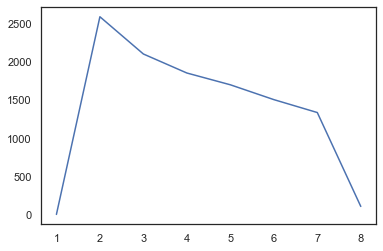

In [50]:
plt.plot('week_purchase' , 'revene_week', data=df_ggg)

<h4>Расчет ROMI</h4>
Для расчета ROMI необходимо ltv кагорты и затраты на привлечение пользователя. Затраты на привлечение 1 пользователя = 6 дол. 

In [18]:
cohorts = df.groupby(['first_date', 'week_after_trial'])['revene_week'].sum().reset_index()
report = pd.merge(size_cohorts, cohorts, on='first_date')

report['ltv'] = report['revene_week'] / report['size_cohorts']
report['romi'] = report['ltv'] / 6.00
# report.head()
output = report.pivot_table(
    index='first_date', columns='week_after_trial', values='romi', aggfunc='mean'
).round(2)

output.fillna('') 
output.cumsum(axis=1).head(10)


week_after_trial,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
first_date,,,,,,,,
2020-01-01,0.0,0.32,0.58,0.81,1.03,1.22,1.40,1.54
2020-01-02,0.0,0.32,0.58,0.80,1.00,1.18,1.35,1.39
2020-01-03,0.0,0.31,0.56,0.78,0.98,1.15,1.30,NaN
2020-01-04,0.0,0.33,0.59,0.82,1.03,1.22,1.37,NaN
2020-01-05,0.0,0.33,0.60,0.85,1.06,1.25,1.40,NaN
2020-01-06,0.0,0.30,0.54,0.75,0.93,1.10,1.23,NaN
2020-01-07,0.0,0.30,0.54,0.75,0.94,1.10,1.22,NaN
2020-01-08,0.0,0.29,0.53,0.74,0.93,1.11,1.24,NaN
2020-01-09,0.0,0.26,0.48,0.67,0.83,0.98,1.02,NaN


в среднем, к 4-5 неделе жизни все когорты уже окупились либо близки к этому. 

<h3>Расчет Retention на полгода</h3>
Для начала расчитаем retention по доступным данным, а затем построим апроксимацию на следующие полгода.

In [19]:
cohorts1 = df.groupby(['first_date', 'week_after_trial'])['user_id'].nunique().reset_index()
cohorts1.head()

,first_date,week_after_trial,user_id
0,2020-01-01,0.0,906
1,2020-01-01,1.0,344
2,2020-01-01,2.0,278
3,2020-01-01,3.0,253
4,2020-01-01,4.0,239


In [20]:
pd_retention = pd.DataFrame(columns=['first_date', 'week_after_trial', 'user_id', 'retention'])

for index in df_pivot3.index:
    user_by_week = cohorts1.loc[cohorts.first_date == index]
    total_users =  (size_cohorts[size_cohorts.first_date == index]['size_cohorts'])
    user_by_week['retention'] = (user_by_week['user_id'] / int(total_users)).round(4)
    pd_retention = pd.concat([pd_retention, user_by_week])
  

In [21]:
pd_retention.head(10)

,first_date,week_after_trial,user_id,retention
0,2020-01-01 00:00:00,0.0,906,1.0
1,2020-01-01 00:00:00,1.0,344,0.3797
2,2020-01-01 00:00:00,2.0,278,0.3068
3,2020-01-01 00:00:00,3.0,253,0.2792
4,2020-01-01 00:00:00,4.0,239,0.2638
5,2020-01-01 00:00:00,5.0,208,0.2296
6,2020-01-01 00:00:00,6.0,194,0.2141
7,2020-01-01 00:00:00,7.0,150,0.1656
8,2020-01-02 00:00:00,0.0,1300,1.0
9,2020-01-02 00:00:00,1.0,503,0.3869


In [22]:
retention_pivot = pd_retention.pivot_table(
    index='first_date',
    columns='week_after_trial',
    values='retention',
    aggfunc='median',
) 

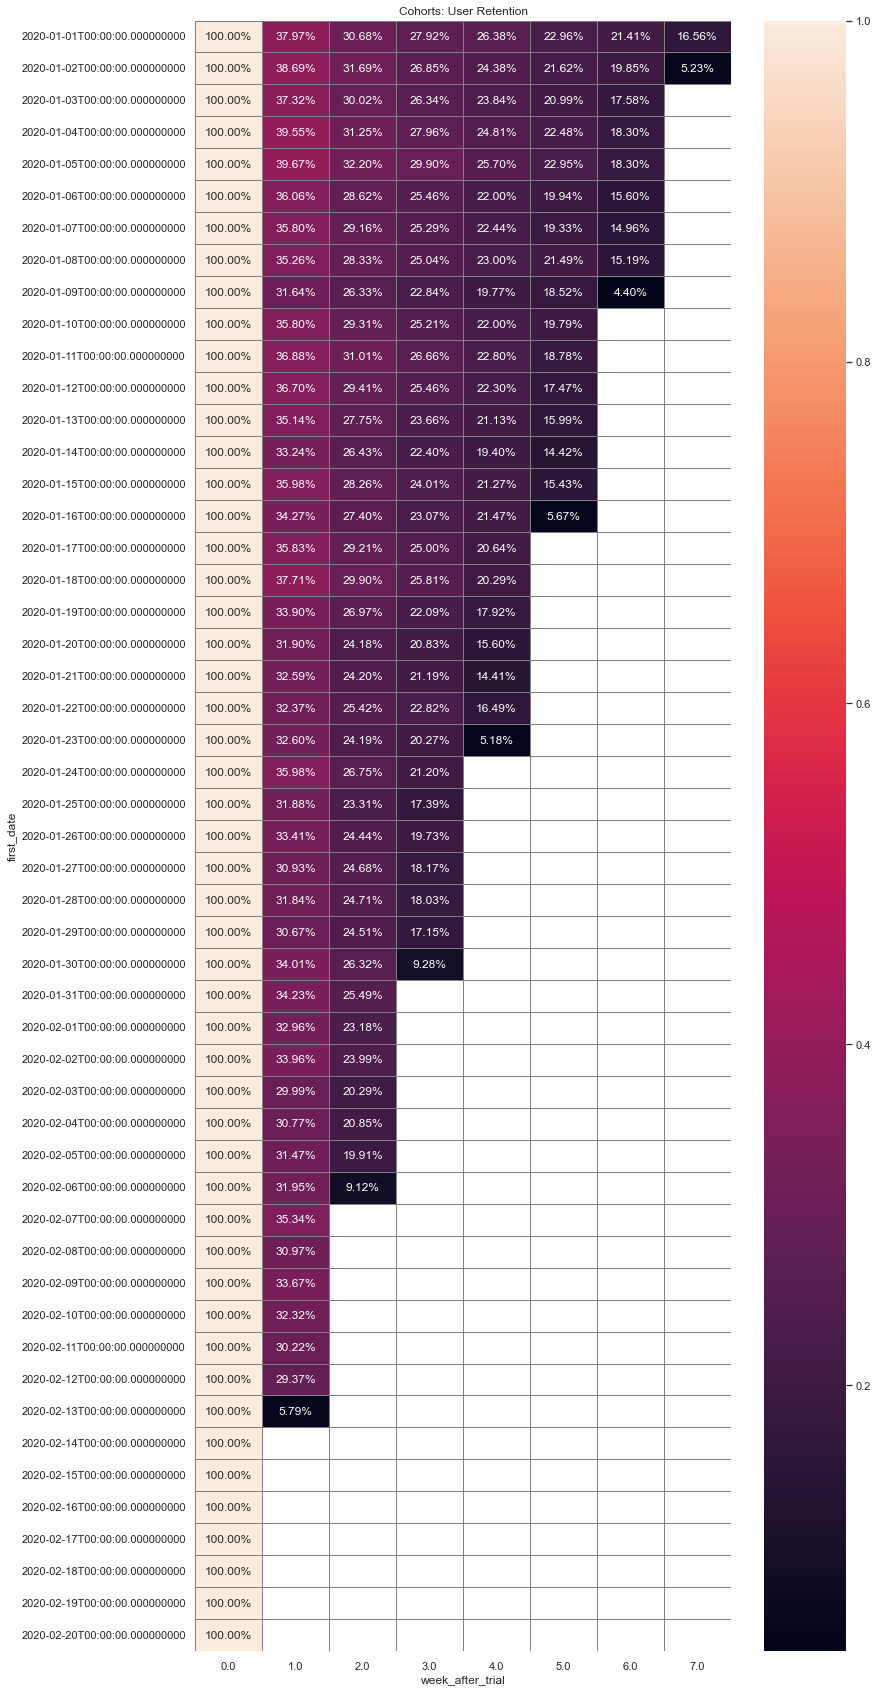

In [23]:
sns.set(style='white')
plt.figure(figsize=(12, 30))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray'); 

Мы получили retention для каждой когорты. можно сказать, что retention в покупку первой платной подписки колеблется от 30 до 40%, второй подписки - 20-30%. Рассчитаем медианные значения по когортам, чтобы на этих цифрах постоить модель retention на следующие полгода. Для этого сгруппируем данные по week_after_trial и рассчитаем медианный retention по неделям.

In [24]:
retention_pivot_per_week = pd_retention.pivot_table(
    index='week_after_trial',
    # columns='week_after_trial',
    values='retention',
    aggfunc='median',
) 

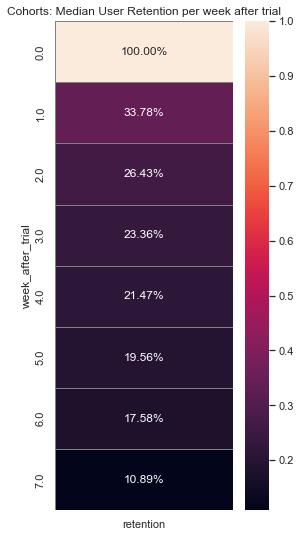

In [25]:
sns.set(style='white')
plt.figure(figsize=(4, 9))
plt.title('Cohorts: Median User Retention per week after trial')
sns.heatmap(retention_pivot_per_week, annot=True, fmt='.2%', linewidths=1, linecolor='gray'); 

Для построения модели retention не будем брать данные за последнюю неделю - там всего два наблюдения - это довольно мало. <br>
Далее я изучила способы предсказания retention на длительный срок и выбрала метод аппроксимации на основе формулы гиперболической регрессии: y= k + b/x, где x-неделя кагорты (1-оформление триала и т.д), k и b - коэффициенты уравнения, определяющие форму графика, y - retention в формате 0,3333(33,33%) <br>
Далее с помощью сайта https://planetcalc.com/ подобрала коэффициенты наиболее достоверно аппроксимирующий график retention по имеющимся данным
 <br>Источник: статья https://vc.ru/promo/81060-how-to-ltv#1

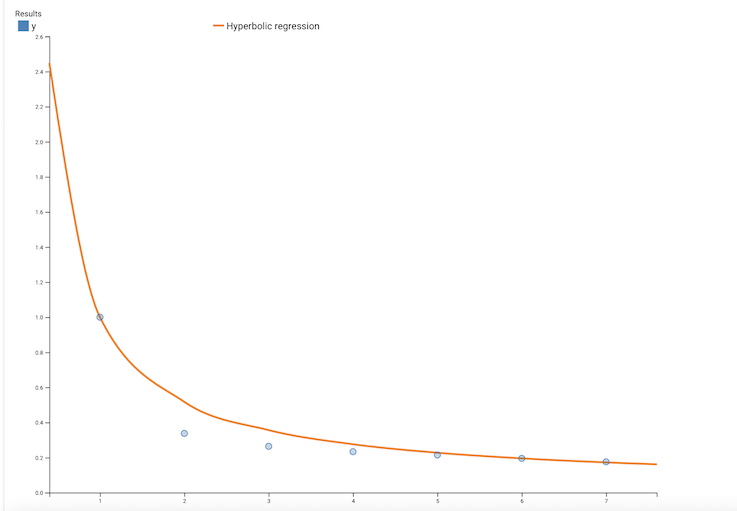

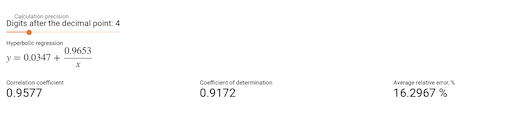

Внешний вид полученного графика. Синим обозначены реальные значения retention, оранжевая линия - спрогнозированный retention. Можно отметить, что retention второй и третьей недели значительно завышен, но далее оранжевая линия соединяется с синими точками. 

Необходимо предсказать retention на полгода - 26 недель, воспользуемся функцией для предсказания

In [26]:
hyperbolic = []

for x in range(1, 27):
    y = 0.0347 + 0.9653/x
    hyperbolic.append({'week': x, 'retention_per_cent': y})

In [27]:
hyperbolic = pd.DataFrame(hyperbolic, columns=['week', 'retention_per_cent'])
hyperbolic.head()

,week,retention_per_cent
0,1,1.000000
1,2,0.517350
2,3,0.356467
3,4,0.276025
4,5,0.227760


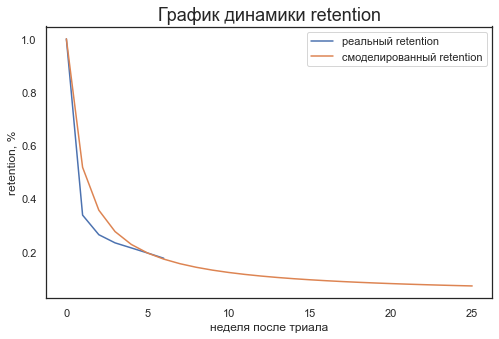

In [28]:
retention_pivot_per_week= retention_pivot_per_week.reset_index()

fig, ax = plt.subplots(figsize=(8, 5))
# x=np.arange(len(pd_ltv.cohorts))
ax.plot('week_after_trial', 'retention', data = retention_pivot_per_week[:7], label='реальный retention')
ax.plot(hyperbolic.index,'retention_per_cent', data=hyperbolic, label='смоделированный retention')


plt.xlabel('неделя после триала')
plt.legend()
plt.ylabel('retention, %')
plt.title(f'График динамики retention', fontsize=18)


plt.show()

<h3>Расчет LTV, ROMI за полгода </h3>
для примера рассчитаем LTV и ROMI для кагорты, сформированной 2020-01-03

In [29]:
pd_retention.first_date = pd.to_datetime(pd_retention.first_date)

retenrion01 = pd_retention[pd_retention.first_date == '2020-01-03']
retenrion01


,first_date,week_after_trial,user_id,retention
16,2020-01-03,0.0,1439,1.0
17,2020-01-03,1.0,537,0.3732
18,2020-01-03,2.0,432,0.3002
19,2020-01-03,3.0,379,0.2634
20,2020-01-03,4.0,343,0.2384
21,2020-01-03,5.0,302,0.2099
22,2020-01-03,6.0,253,0.1758


In [30]:
ret_hyperb = hyperbolic
ret_hyperb['retention'] = np.floor(ret_hyperb.retention_per_cent * 1439)
ret_hyperb.head(10)

,week,retention_per_cent,retention
0,1,1.000000,1439.0
1,2,0.517350,744.0
2,3,0.356467,512.0
3,4,0.276025,397.0
4,5,0.227760,327.0
5,6,0.195583,281.0
6,7,0.172600,248.0
7,8,0.155363,223.0
8,9,0.141956,204.0
9,10,0.131230,188.0


Модель в начале завышает retention, но потом retention выравнивается

In [31]:
ret_hyperb['revenue'] = ret_hyperb.retention * 4.99
ret_hyperb.head()

ltv = ((ret_hyperb['revenue'].sum() - 7180.61) / 1439).round(2)
romi = (ltv - 6).round(2)
print('Предсказанный полугодовой ltv =', ltv, 'предсказанный полугодовой romi =', romi)

Предсказанный полугодовой ltv = 18.04 предсказанный полугодовой romi = 12.04


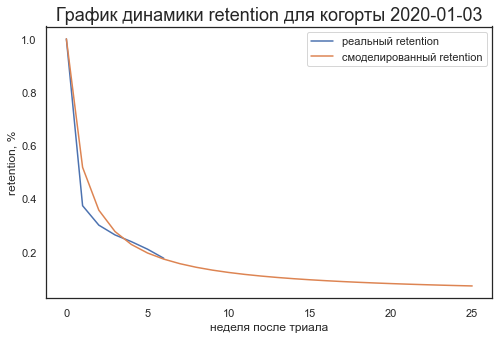

In [32]:

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot('week_after_trial', 'retention', data = retenrion01, label='реальный retention')
ax.plot(hyperbolic.index ,'retention_per_cent', data=ret_hyperb, label='смоделированный retention')


plt.xlabel('неделя после триала')
plt.legend()
plt.ylabel('retention, %')
plt.title(f'График динамики retention для когорты 2020-01-03', fontsize=18)


plt.show()

<h3>Выводы</h3>

   - У всех когорт положительный LTV, который нарастает по мере «взросления» когорты. <br>
   - Медианная конверсия в покупку подписки после триала на первой неделе составляет 34%, на  второй неделе – 26,5%, на третьей-шестой – снижается до 17%. <br>
   - При САС равной 6 дол, когорты окупаются к 4-5 неделе приобретения платной подписки. <br>
   - Построена модель прогнозирования Retention на полгода, который вычисляется по формуле гиперболической регрессии: y= k + b/x, где x-неделя кагорты (1-оформление триала и т.д), k и b - коэффициенты уравнения, определяющие форму графика, y - Retention в формате 0,3333(33,33%).  <br>
   - Предсказанный полугодовой LTV = 18.04 дол , ROMI = 12.04 дол. . 